<a href="https://colab.research.google.com/github/karsarobert/DeepLearning2024/blob/main/10/PTE_DL10_Timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
keras = tf.keras

In [ ]:
temp = pd.read_csv(
    "https://raw.githubusercontent.com/karsarobert/Deep-Learning-2023/main/temp.csv",
    names=["Oszlop1"]).values

In [ ]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Idő")
    plt.ylabel("Hőmérséklet")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)



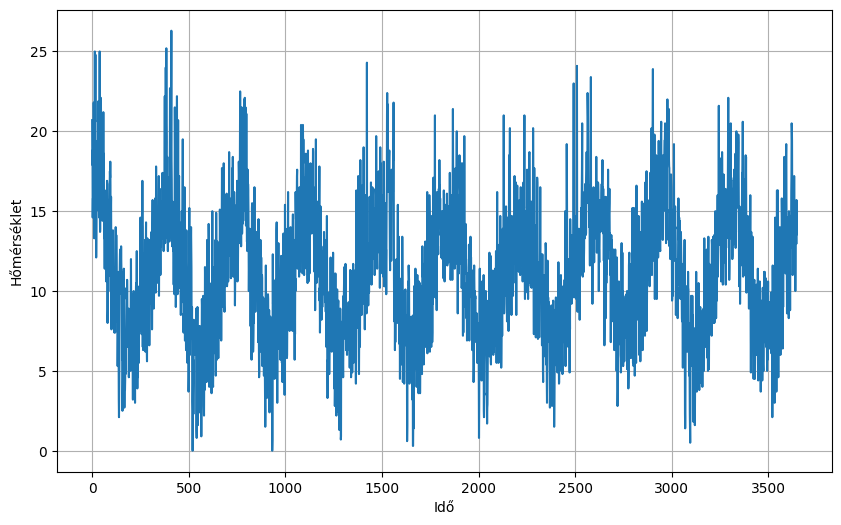

In [ ]:
time = np.arange(3647)
series = temp.reshape(3647,)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Előrejelzés gépi tanulással

Először is, egy modellt fogunk képezni a következő lépés előrejelzésére az előző 30 lépés alapján, ezért létre kell hoznunk egy 30 lépésből álló ablakokból álló adathalmazt a képzéshez.


In [ ]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series) # belovassa az adatokat tf.data.Dataset formátumban
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # az adatokat window_size-os ablakokba rendezi és a +1 jelenti az y-t
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # a dataset tensorok formájában tartalmazza az adatokat 5-ösével
    dataset = dataset.shuffle(shuffle_buffer) # összekeverjük az adatokat
    dataset = dataset.map(lambda window: (window[:-1], window[-1])) # a tensorokat szétvágjuk x, y-ra ahol y a kimenet
    dataset = dataset.batch(batch_size).prefetch(1) # beállítjuk a batch méretet 2-re és előkészítjük a következő adatokat is
    return dataset

In [ ]:
split_time = 1000 # előállítjuk a train és valid adatokat numpy array szeleteléssel
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

A statisztikákban a Huber veszteség a robusztus regresszióban használt veszteségfüggvény, amely kevésbé érzékeny az adatokban szereplő kiugró értékekre, mint a négyzeteshiba
Kis értékek esetén L2, nagyobb értékek esetén L1-ként viselkedik

Keressük meg a legjobb LR értéket!

Az ábráról az optimális tanulási rátát a következőképpen választhatjuk ki:

Olyan értéket keresünk, ahol a veszteség gyorsan csökken (jellemzően
10
−5
  és
1
0
−
3

  között van az ábrán).
Kerüljük azokat a tartományokat, ahol a veszteség növekedni kezd.


<img src="https://pyimagesearch.com/wp-content/uploads/2019/08/keras_learning_rate_finder_header.png">

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size]) # nincs aktivációs fgv így csak egy lineáris fgv ként viselkedik
])
# beállítunk egy LR ütemezőt nagyon kis értéktől indulunk és folyamatosan növeljük a LR-t
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 7ms/step - loss: 4.5107 - mae: 4.9896 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 4.1321 - mae: 4.6072 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 3.8068 - mae: 4.2797 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 3.5768 - mae: 4.0465 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 1s 7ms/step - loss: 3.4199 - mae: 3.8909 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 3.3206 - mae: 3.7912 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 3.2578 - mae: 3.7296 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 3.2241 - mae: 3.6964 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 1s 5ms/step - loss: 3.2032 - mae: 3.6755 - lr: 1.8478e-06
E

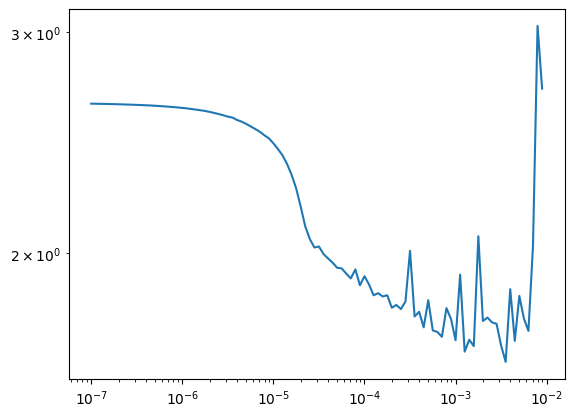

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-6, 1e-3, 0, 20])
plt.yscale('log')

# Meg keressük a legnagyobb LR-t amit még használhatunk!

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size) # előállítjuk a dataseteket a korábbi fgv segítségével
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9) # lehet próbálkozni mással is pl adam
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10) # korai megállás ha 10 korszakon keresztül nem javulnak a lossok
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 29ms/step - loss: 6.1934 - mae: 6.6784 - val_loss: 4.6847 - val_mae: 5.1679
Epoch 2/500
31/31 [==============================] - 1s 24ms/step - loss: 3.4397 - mae: 3.9129 - val_loss: 3.9928 - val_mae: 4.4744
Epoch 3/500
31/31 [==============================] - 1s 17ms/step - loss: 2.6175 - mae: 3.0805 - val_loss: 2.6516 - val_mae: 3.1212
Epoch 4/500
31/31 [==============================] - 2s 47ms/step - loss: 2.3104 - mae: 2.7713 - val_loss: 1.7009 - val_mae: 2.1479
Epoch 5/500
31/31 [==============================] - 1s 31ms/step - loss: 2.3440 - mae: 2.8058 - val_loss: 2.4630 - val_mae: 2.9323
Epoch 6/500
31/31 [==============================] - 2s 48ms/step - loss: 2.1334 - mae: 2.5922 - val_loss: 1.5029 - val_mae: 1.9492
Epoch 7/500
31/31 [==============================] - 1s 17ms/step - loss: 2.1253 - mae: 2.5790 - val_loss: 2.0276 - val_mae: 2.4875
Epoch 8/500
31/31 [==============================] - 1s 23ms/step - loss: 2.

In [ ]:
for element in train_set.take(1):
  print(element)
# egy dataset tartalma 30 elem ennyi volt az ablak méret, és 32 db ilyen 30-as tensor a batch méret miatt

(<tf.Tensor: shape=(32, 30), dtype=float64, numpy=
array([[ 8.6,  6.1, 13.2,  9.9,  4.7,  5.8, 14.9, 10.7,  8.6,  9.4,  5.7,
        10.9, 13.1, 10.4,  8.2,  9.8,  7.5,  5.8,  9.8,  7.9,  8.7, 10. ,
        10.6,  8. , 10.2, 15.1, 13.9,  9.2,  9. , 13.2],
       [14.4, 14.4, 18.5, 16.9, 17.5, 21.2, 17.8, 18.6, 17. , 16. , 13.3,
        14.3, 11.4, 16.3, 16.1, 11.8, 12.2, 14.7, 11.8, 11.3, 10.6, 11.7,
        14.2, 11.2, 16.9, 16.7,  8.1,  8. ,  8.8, 13.4],
       [13.1, 10.4,  8.2,  9.8,  7.5,  5.8,  9.8,  7.9,  8.7, 10. , 10.6,
         8. , 10.2, 15.1, 13.9,  9.2,  9. , 13.2,  7. , 10.6,  6.9,  9.5,
        12.5, 13.6, 17.7, 16. , 11.3, 10.5, 14.4, 10.3],
       [ 8.1, 10.1, 10.6,  5.3,  6.6,  8.5, 11.2,  9.8,  5.9,  3.2,  2.1,
         3.4,  5.4,  9.6, 11.5, 12.3, 12.6, 11. , 11.2, 11.4, 11.8, 12.8,
        11.6, 10.6,  9.8, 11.2,  5.7,  7.1,  2.5,  3.5],
       [ 7.8,  6.2,  5.6, 10. , 13.3,  8.3, 10.2,  8.6,  7.3, 10.4, 11.2,
        13.2, 11.4,  9.1,  6.6,  8.4,  9.7, 13.2, 12.5,

In [ ]:
def model_forecast(model, series, window_size):  # ua mint feljebb a window_dataset fgv annyi eltéréssel, hogy itt nem kell y-t generálni
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0] # előrejelzés készítése

83/83 [==============================] - 0s 5ms/step


In [ ]:
lin_forecast.shape

(2647,)

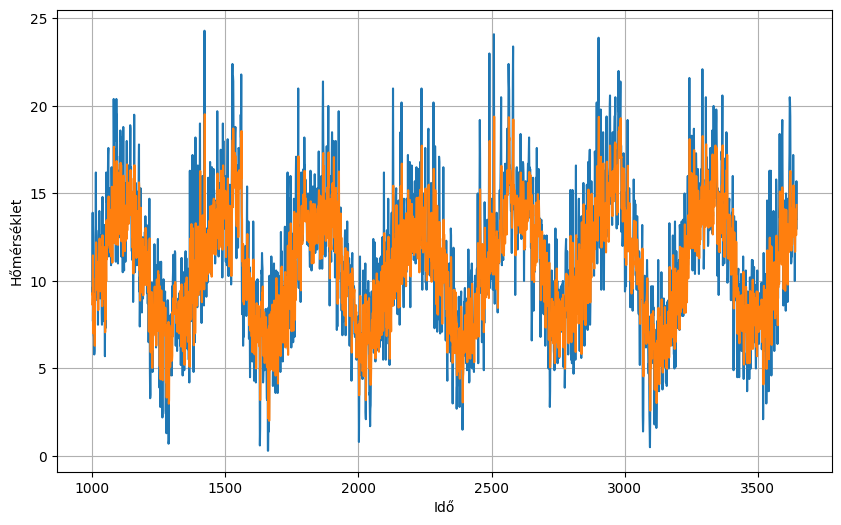

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1.9202814

### Dense Model Forecasting

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])
# LR kereséshez a beállítások ua mint feljebb
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 16.1800 - mae: 16.6800 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 16.1090 - mae: 16.6090 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 16.0234 - mae: 16.5234 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 15.9273 - mae: 16.4273 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 15.8194 - mae: 16.3194 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 15.6982 - mae: 16.1982 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 15.5631 - mae: 16.0631 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 15.4107 - mae: 15.9107 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 15.2406 - mae: 15.7406 

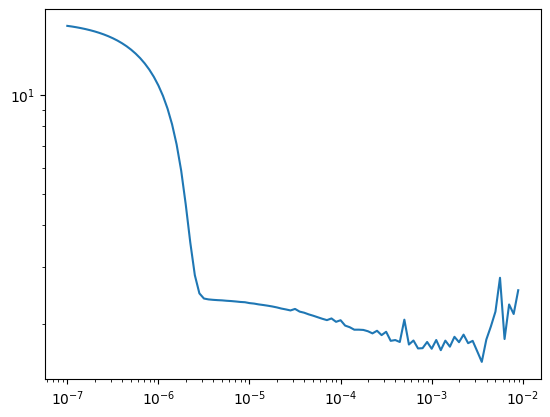

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.yscale('log')
#plt.axis([1e-7, 5e-3, 0, 30])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(learning_rate=8e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 2s 28ms/step - loss: 12.5991 - mae: 13.0981 - val_loss: 6.2981 - val_mae: 6.7943
Epoch 2/500
31/31 [==============================] - 1s 15ms/step - loss: 3.0030 - mae: 3.4675 - val_loss: 1.8297 - val_mae: 2.2805
Epoch 3/500
31/31 [==============================] - 1s 23ms/step - loss: 2.1138 - mae: 2.5732 - val_loss: 1.8161 - val_mae: 2.2664
Epoch 4/500
31/31 [==============================] - 1s 24ms/step - loss: 2.0955 - mae: 2.5558 - val_loss: 1.8000 - val_mae: 2.2499
Epoch 5/500
31/31 [==============================] - 1s 15ms/step - loss: 2.0694 - mae: 2.5308 - val_loss: 1.7924 - val_mae: 2.2420
Epoch 6/500
31/31 [==============================] - 1s 16ms/step - loss: 2.0558 - mae: 2.5171 - val_loss: 1.7979 - val_mae: 2.2482
Epoch 7/500
31/31 [==============================] - 1s 16ms/step - loss: 2.0485 - mae: 2.5088 - val_loss: 1.7837 - val_mae: 2.2334
Epoch 8/500
31/31 [==============================] - 1s 23ms/step - loss: 

In [ ]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

83/83 [==============================] - 0s 5ms/step


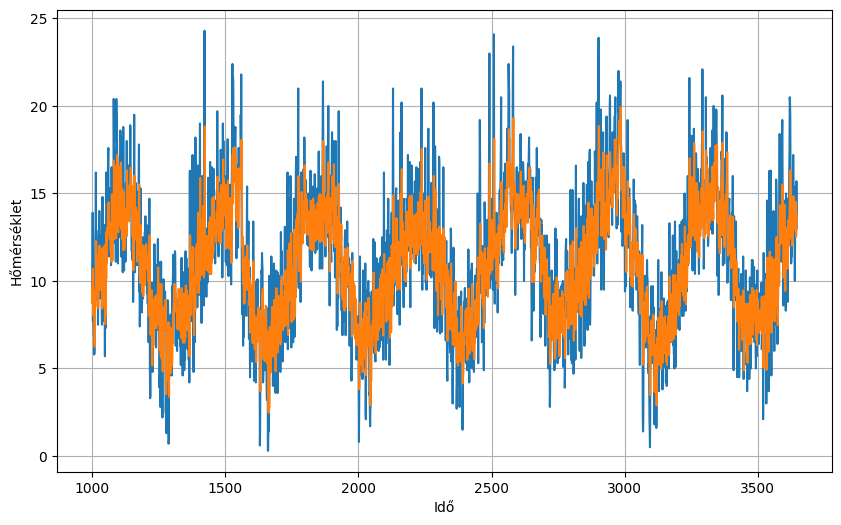

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [ ]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

1.9243582